In [1]:
# Imports - Ensure all are installed
import numpy as np 
import pandas as pd 
import yfinance as yf 
import matplotlib.pyplot as plt 
from scipy.optimize import minimize 
from datetime import date
from dateutil.relativedelta import relativedelta
import scipy.stats as stats

In [2]:
# Data Collection
# Stock Data: Download historical daily stock price data for the 5 selected stocks over the last 5 years
tickers = ['ABB.NS', 'INDHOTEL.NS', 'OBEROIRLTY.NS', 'TVSMOTOR.NS', 'USHAMART.NS']
endDate = date.today()
startDate = date.today() - relativedelta(years = 5)
data = yf.download(tickers, start= startDate, end = endDate)['Adj Close']
print(data)

# Risk-Free Rate Data: Obtain the latest risk-free rate from the Reserve Bank of India (RBI) website. Use the 10-year Government Bond Yield as the risk-free rate in your calculations.
riskFreeRateRBI = 0.068 # 6.80% according to RBI's website 

[*********************100%***********************]  5 of 5 completed

Ticker                          ABB.NS  INDHOTEL.NS  OBEROIRLTY.NS  \
Date                                                                 
2019-10-14 00:00:00+00:00  1304.680786   144.938644     488.936554   
2019-10-15 00:00:00+00:00  1320.830444   142.125687     497.809326   
2019-10-16 00:00:00+00:00  1340.951538   142.078018     499.928925   
2019-10-17 00:00:00+00:00  1340.774902   144.795609     508.062225   
2019-10-18 00:00:00+00:00  1373.427124   142.459442     532.412964   
...                                ...          ...            ...   
2024-10-07 00:00:00+00:00  7758.299805   653.049988    1748.099976   
2024-10-08 00:00:00+00:00  8154.649902   684.650024    1759.599976   
2024-10-09 00:00:00+00:00  8458.049805   693.650024    1834.650024   
2024-10-10 00:00:00+00:00  8510.299805   706.250000    1879.250000   
2024-10-11 00:00:00+00:00  8553.700195   708.549988    1919.150024   

Ticker                     TVSMOTOR.NS  USHAMART.NS  
Date                               

In [3]:
# Data Preparation
# Calculate daily returns for each stock.
returns = data.pct_change().dropna()
print(returns)

# Compute the mean returns and the covariance matrix for the daily returns.
meanReturns = returns.mean()
covReturns = returns.cov()
print(f'Mean Returns:\n{meanReturns}')
print(f'Covariance Matrix for Returns:\n{covReturns}')

Ticker                       ABB.NS  INDHOTEL.NS  OBEROIRLTY.NS  TVSMOTOR.NS  \
Date                                                                           
2019-10-15 00:00:00+00:00  0.012378    -0.019408       0.018147     0.031698   
2019-10-16 00:00:00+00:00  0.015234    -0.000335       0.004258     0.003901   
2019-10-17 00:00:00+00:00 -0.000132     0.019127       0.016269     0.068254   
2019-10-18 00:00:00+00:00  0.024353    -0.016134       0.047929     0.037972   
2019-10-22 00:00:00+00:00 -0.010988     0.019411      -0.050273    -0.010734   
...                             ...          ...            ...          ...   
2024-10-07 00:00:00+00:00 -0.021701    -0.012699      -0.033344    -0.018474   
2024-10-08 00:00:00+00:00  0.051087     0.048388       0.006579     0.038933   
2024-10-09 00:00:00+00:00  0.037206     0.013145       0.042652     0.015325   
2024-10-10 00:00:00+00:00  0.006178     0.018165       0.024310     0.003935   
2024-10-11 00:00:00+00:00  0.005100     

In [4]:
# Constructing the Optimal Portfolio Using Markowitz Model
# Use the Markowitz mean-variance optimization model to find the optimal weights for a portfolio of all Nifty 50 stocks.

#Function to calculate portfolio performance
def portfolioPerformance(weights, returns, riskFreeRate = riskFreeRateRBI): #Oct 2024 yield for 10Y govt. bond
    portfolioReturn = np.sum(returns.mean() * weights) * 252
    portflioStandardDeviation = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpeRatio = (portfolioReturn - riskFreeRate)/(portflioStandardDeviation)
    return portfolioReturn, portflioStandardDeviation, sharpeRatio

#Ensure sum of weights = 1, constraints
def checkSumOfWeights(weights):
    return np.sum(weights) - 1

#Function to minimize
def minimizeInverseSharpeRatio(weights):
    return 1/portfolioPerformance(weights, returns)[2]

constraints = ({'type': 'eq', 'fun': checkSumOfWeights}) 
bounds = tuple((0,1) for _ in range(len(tickers)))
initialWeights = len(tickers)*[1/len(tickers)]

# Adjust the Sharpe ratio calculation using the risk-free rate obtained from the RBI website
# Perform the optimization to find the portfolio with the maximum Sharpe ratio (risk-adjusted return).
optimizedResult = minimize(minimizeInverseSharpeRatio, initialWeights, method='SLSQP', bounds=bounds, constraints=constraints)
optimizedWeights = optimizedResult.x
optimizedReturn, optimizedStandardDeviation, optimizedSharpeRatio = portfolioPerformance(optimizedWeights, returns)

# Convert weights to percentage for readability
optimizedWeightsPercentage = ['']*len(optimizedWeights)
for i in range (len(optimizedWeights)):
    optimizedWeightsPercentage[i] = f'{optimizedWeights[i]*100:.2f}%' 

weightsByStockMarkowitz = {}
for i in range(len(tickers)):
    weightsByStockMarkowitz[tickers[i]] = [optimizedWeightsPercentage[i]]
weightsByStockMarkowitz = pd.DataFrame(weightsByStockMarkowitz)
print('Markowitz mean-variance optimization model:')
print(f'Optimized Weights:\n {weightsByStockMarkowitz}')
print(f'Optimized Returns: {optimizedReturn*100:.2f}%')
print(f'Optimized Standard Deviation: {optimizedStandardDeviation*100:.2f}%')
print(f'Optimized Sharpe Ratio: {optimizedSharpeRatio*100:.2f}%')

Markowitz mean-variance optimization model:
Optimized Weights:
    ABB.NS INDHOTEL.NS OBEROIRLTY.NS TVSMOTOR.NS USHAMART.NS
0  29.50%       6.19%         4.44%      35.70%      24.18%
Optimized Returns: 50.43%
Optimized Standard Deviation: 25.31%
Optimized Sharpe Ratio: 172.40%


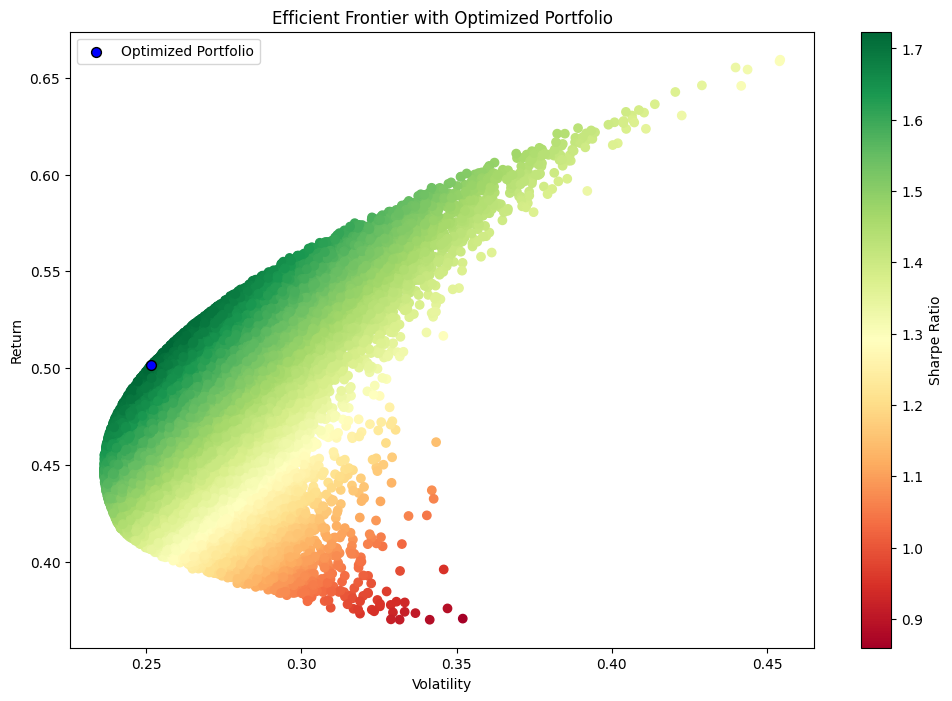

From the randomly generated portfolios, the best portfolio is:
Optimized Weights:
    ABB.NS INDHOTEL.NS OBEROIRLTY.NS TVSMOTOR.NS USHAMART.NS
0  28.38%       6.75%         4.98%      36.56%      23.33%
Optimized Returns: 50.14%
Optimized Standard Deviation: 25.15%
Optimized Sharpe Ratio: 172.34%


In [5]:
# Monte Carlo Simulation
# Generate random portfolio weights and calculate the expected returns and risks for a large number of portfolios (e.g., 10,000)
numPortfolio = 100000 # 100,000 portfolios
allWeights = np.zeros((numPortfolio, len(tickers)))
retArr = np.zeros(numPortfolio)
stdArr = np.zeros(numPortfolio)
sharpeArr = np.zeros(numPortfolio)

maxSharpe = 0
bestPortfolio = []
bestWeights = []
np.random.seed(42) # For reproducibility and consistency
for i in range(numPortfolio):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    allWeights [i, :] = weights
    retArr[i], stdArr[i], sharpeArr[i] = portfolioPerformance(weights, returns)
    if(sharpeArr[i]> maxSharpe):
        maxSharpe = sharpeArr[i]
        bestPortfolio = [retArr[i], stdArr[i]]
        bestWeights = weights

# Plot the Efficient Frontier using the results from the Monte Carlo simulation
plt.figure(figsize=(12,8))
plt.scatter(stdArr, retArr, c = sharpeArr, cmap='RdYlGn')
plt.colorbar(label = "Sharpe Ratio")

# Identify the portfolio with the maximum Sharpe ratio and minimum risk from the simulation results
plt.scatter(bestPortfolio[1], bestPortfolio[0], c = 'blue', s = 50, edgecolors='black', label = 'Optimized Portfolio') # Plot the best portfolio from the randomly generated ones
plt.title('Efficient Frontier with Optimized Portfolio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.legend()
plt.show()

# Convert weights to percentage for readability
bestWeightsPercentage = ['']*len(bestWeights)
for i in range (len(bestWeights)):
    bestWeightsPercentage[i] = f'{bestWeights[i]*100:.2f}%' 

weightsByStockMonteCarlo = {}
for i in range(len(tickers)):
    weightsByStockMonteCarlo[tickers[i]] = [bestWeightsPercentage[i]]
weightsByStockMonteCarlo = pd.DataFrame(weightsByStockMonteCarlo)

# Print the portfolio with the maximum Sharpe ratio and minimum risk from the simulation results
print('From the randomly generated portfolios, the best portfolio is:')
print(f'Optimized Weights:\n {weightsByStockMonteCarlo}')
print(f'Optimized Returns: {bestPortfolio[0]*100:.2f}%')
print(f'Optimized Standard Deviation: {bestPortfolio[1]*100:.2f}%')
print(f'Optimized Sharpe Ratio: {maxSharpe*100:.2f}%')

In [6]:
# Risk Analysis
# Calculate the standard deviation (volatility) of the optimal portfolio returns to measure overall risk
# Assumption: You want us to use the best randomly generated portfolio
volatility = bestPortfolio[1]
expectedReturn = bestPortfolio[0]

# Calculate the VaR for the optimal portfolio at a 95% confidence level
def calculate_value_at_risk(expectedReturn, confidenceLevel):
    zScore = stats.norm.ppf(1 - confidenceLevel)
    VaR = expectedReturn + zScore * volatility
    return abs(VaR)

# Display the VaR
confidenceLevel = 0.95
print(f'VaR for the optimal portfolio at a 95% confidence level: {calculate_value_at_risk(expectedReturn, confidenceLevel)*100:.2f}%')

VaR for the optimal portfolio at a 95% confidence level: 8.78%
